## Baseline Deep Hedging

Train and evaluate baseline dense network for deep hedging.

In [19]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import torch
import json
from pathlib import Path

from src.utils.config import load_config, get_device
from src.models.deep_hedging import DeepHedgingNetwork, create_model
from src.models.losses import create_loss_function
from src.models.trainer import Trainer
from src.data.heston import get_or_generate_dataset
from src.data.preprocessor import create_dataloaders, compute_features
from src.evaluation.metrics import compute_all_metrics, print_metrics
from src.evaluation.baselines import DeltaHedgingBaseline, evaluate_all_baselines
from src.utils.visualization import plot_pnl_distribution

### 1. Load Configuration and Data

In [20]:
config = load_config('../configs/config.yaml')
device = get_device(config)
print(f"Using device: {device}")

# Extract key parameters
heston_config = config['data']['heston']
K = heston_config['K']
T = config['data']['T']
n_steps = config['data']['n_steps']
dt = T / n_steps

print(f"K={K}, T={T}, n_steps={n_steps}, dt={dt:.6f}")

# Load/generate data using caching system
cache_dir = config.get('caching', {}).get('directory', 'cache')

S_train, v_train, Z_train = get_or_generate_dataset(config, 'train', cache_dir)
S_val, v_val, Z_val = get_or_generate_dataset(config, 'val', cache_dir)
S_test, v_test, Z_test = get_or_generate_dataset(config, 'test', cache_dir)

print(f"Data shapes: Train={S_train.shape}, Val={S_val.shape}, Test={S_test.shape}")

[Config] Auto-detected device: cpu
Using device: cpu
K=100.0, T=0.0833, n_steps=30, dt=0.002777
[Heston] Loading cached train dataset from cache/train_146f79df.npz
[Heston] Loading cached val dataset from cache/val_2bd7a7b3.npz
[Heston] Loading cached test dataset from cache/test_c0f922ca.npz
Data shapes: Train=(150000, 31), Val=(15000, 31), Test=(15000, 31)


### 2. Create DataLoaders

In [21]:
batch_size = config.get('training', {}).get('batch_size', 256)

train_loader, val_loader, test_loader = create_dataloaders(
    S_train, v_train, Z_train,
    S_val, v_val, Z_val,
    S_test, v_test, Z_test,
    batch_size=batch_size
)

print(f"DataLoaders created with batch_size={batch_size}")

DataLoaders created with batch_size=1024


### 3. Create Model and Loss Function

In [22]:
model = create_model(config)
loss_fn = create_loss_function(config)

print(f"Model architecture:")
print(model)
print(f"\nTotal parameters: {model.get_num_parameters():,}")
print(f"Loss function: {loss_fn}")

# Save initial weights
exp_dir = Path('../experiments/baseline')
exp_dir.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), exp_dir / 'init_weights.pt')
print("Initial weights saved")

[Model] Created DeepHedgingNetwork
        Input: 5 exogenous + 3 recurrent = 8 total
        Parameters: 101,122
[Loss] Created OCELoss (CVaR α=0.05, TC=0.001)
Model architecture:
DeepHedgingNetwork(
  (activation_fn): ReLU()
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

Total parameters: 101,122
Loss function: OCELoss()
Initial weights saved


### 4. Train Model

In [23]:
trainer = Trainer(
    model=model,
    loss_fn=loss_fn,
    config=config,
    device=device
)

# Set checkpoint directory
trainer.checkpoint_dir = str(exp_dir / 'checkpoints')
Path(trainer.checkpoint_dir).mkdir(parents=True, exist_ok=True)

print("Starting training...")
training_results = trainer.train(train_loader, val_loader)
print(f"Training complete. Best validation loss: {training_results['best_val_loss']:.6f}")

Starting training...

Starting training from epoch 1
Device: cpu
Loss type: CVAR
Epochs: 300, LR: 0.001
Early stopping patience: 30

Epoch   1/300 | Train Loss: 30.529128 | Val Loss: 29.652275 | PnL Mean: -1.6179 | PnL Std: 2.0413 | CVaR: -7.9781 | Time: 22.5s *
Epoch   2/300 | Train Loss: 27.938194 | Val Loss: 27.009380 | PnL Mean: -1.6245 | PnL Std: 1.3573 | CVaR: -5.6449 | Time: 21.8s *
Epoch   3/300 | Train Loss: 25.481949 | Val Loss: 24.490379 | PnL Mean: -1.6305 | PnL Std: 1.4747 | CVaR: -6.2426 | Time: 23.2s *
Epoch   4/300 | Train Loss: 23.003642 | Val Loss: 22.113751 | PnL Mean: -1.6468 | PnL Std: 1.2489 | CVaR: -5.4103 | Time: 20.7s *
Epoch   5/300 | Train Loss: 20.669736 | Val Loss: 19.690353 | PnL Mean: -1.6508 | PnL Std: 1.1219 | CVaR: -5.1377 | Time: 18.2s *
Epoch   6/300 | Train Loss: 18.426683 | Val Loss: 17.434862 | PnL Mean: -1.6547 | PnL Std: 1.0695 | CVaR: -4.9392 | Time: 18.3s *
Epoch   7/300 | Train Loss: 16.208773 | Val Loss: 15.186011 | PnL Mean: -1.6578 | PnL S

### 5. Plot Training Curves

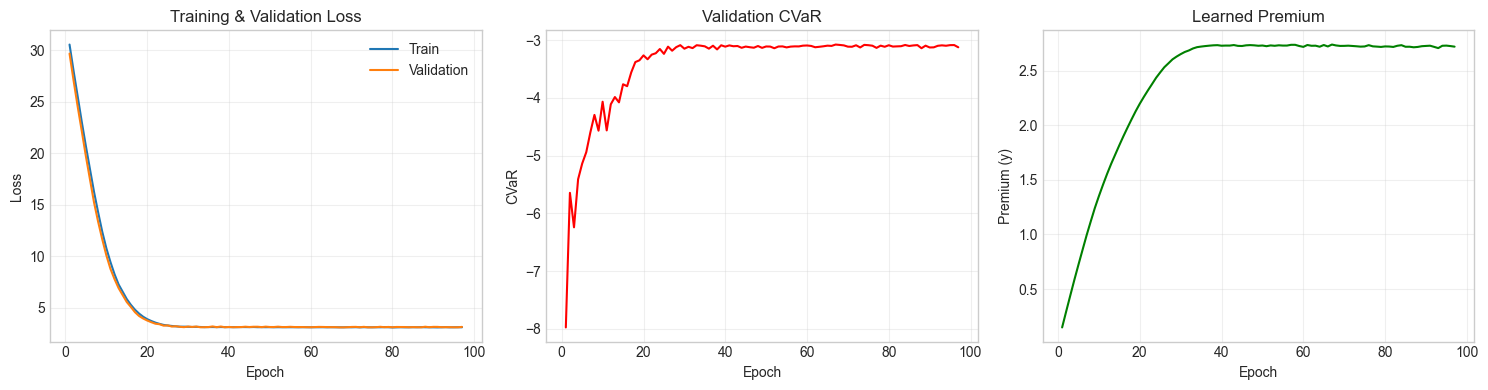

In [24]:
history = trainer.training_history

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curves
epochs = [h['epoch'] for h in history]
train_loss = [h['train_loss'] for h in history]
val_loss = [h['val_loss'] for h in history]

axes[0].plot(epochs, train_loss, label='Train')
axes[0].plot(epochs, val_loss, label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CVaR evolution
val_cvar = [h.get('val_cvar', 0) for h in history]
axes[1].plot(epochs, val_cvar, color='red')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('CVaR')
axes[1].set_title('Validation CVaR')
axes[1].grid(True, alpha=0.3)

# Premium evolution
val_premium = [h.get('val_premium', 0) for h in history]
axes[2].plot(epochs, val_premium, color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Premium (y)')
axes[2].set_title('Learned Premium')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/baseline_training_curves.pdf')
plt.show()

### 6. Evaluate on Test Set

In [25]:
# Load best model
trainer.load_checkpoint('best')
model.eval()

# Compute P&L on test set
all_pnl = []
all_deltas = []

with torch.no_grad():
    for S, v, Z in test_loader:
        S = S.to(device)
        v = v.to(device)
        Z = Z.to(device)
        
        features = compute_features(S, v, K, T, dt)
        deltas, y = model(features, S)
        pnl = loss_fn.compute_pnl(deltas, S, Z, dt)
        
        all_pnl.append(pnl.cpu())
        all_deltas.append(deltas.cpu())

all_pnl = torch.cat(all_pnl).numpy()
all_deltas = torch.cat(all_deltas).numpy()

# Compute metrics
metrics = compute_all_metrics(all_pnl)
metrics['learned_premium'] = float(model.y.item())

print_metrics(metrics, "Test Set Metrics")

# Save metrics
with open(exp_dir / 'metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"\nMetrics saved to {exp_dir / 'metrics.json'}")

/Users/abdoulayetraore/Downloads/Deep_Robust_LTH_project/notebooks/../src/models/trainer.py:393: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, 

[Trainer] Loaded checkpoint 'best' (epoch 67)
[Trainer] Best val loss: 3.075608

                      Test Set Metrics                      

P&L Statistics:
----------------------------------------
  pnl_mean                          -1.703182
  pnl_std                            0.740941
  pnl_min                          -17.932856
  pnl_max                           -0.170326
  pnl_median                        -1.729038
  pnl_skewness                      -1.174907
  pnl_kurtosis                      18.750441
  pnl_iqr                            1.153378

Risk Metrics:
----------------------------------------
  var_05                            -2.720986
  var_01                            -3.158267
  cvar_05                           -3.095830
  cvar_01                           -4.036126
  max_drawdown                   -25547.292969

Performance Ratios:
----------------------------------------
  sharpe_ratio                      -2.298675
  sortino_ratio                     -

### 7. Compare with Delta Hedging Baseline

In [26]:
# Evaluate all baselines
baseline_results = evaluate_all_baselines(S_test, v_test, Z_test, config)

print("\nBaseline Comparison:")
print("=" * 70)
print(f"{'Method':<25} {'Mean P&L':<12} {'Std P&L':<12} {'CVaR 5%':<12} {'Sharpe':<12}")
print("-" * 70)

# Deep Hedging results
print(f"{'Deep Hedging':<25} {metrics['pnl_mean']:<12.4f} {metrics['pnl_std']:<12.4f} {metrics['cvar_05']:<12.4f} {metrics['sharpe_ratio']:<12.4f}")

# Baselines
for name, result in baseline_results.items():
    print(f"{name:<25} {result['mean_pnl']:<12.4f} {result['std_pnl']:<12.4f} {result['cvar_05']:<12.4f} {result['sharpe_ratio']:<12.4f}")

print("=" * 70)


Baseline Comparison:
Method                    Mean P&L     Std P&L      CVaR 5%      Sharpe      
----------------------------------------------------------------------
Deep Hedging              -1.7032      0.7409       -3.0958      -2.2987     
delta_hedging_const_vol   -1.7811      0.6323       -3.5400      -2.8170     
delta_hedging_inst_vol    -1.7866      0.5690       -3.2010      -3.1401     
no_hedging                -1.6180      2.5196       -9.2968      -0.6422     
static_delta_0.5          -1.6289      1.3043       -5.2870      -1.2488     
static_delta_1.0          -1.6397      2.2578       -8.5000      -0.7262     


### 8. Visualize P&L Distribution

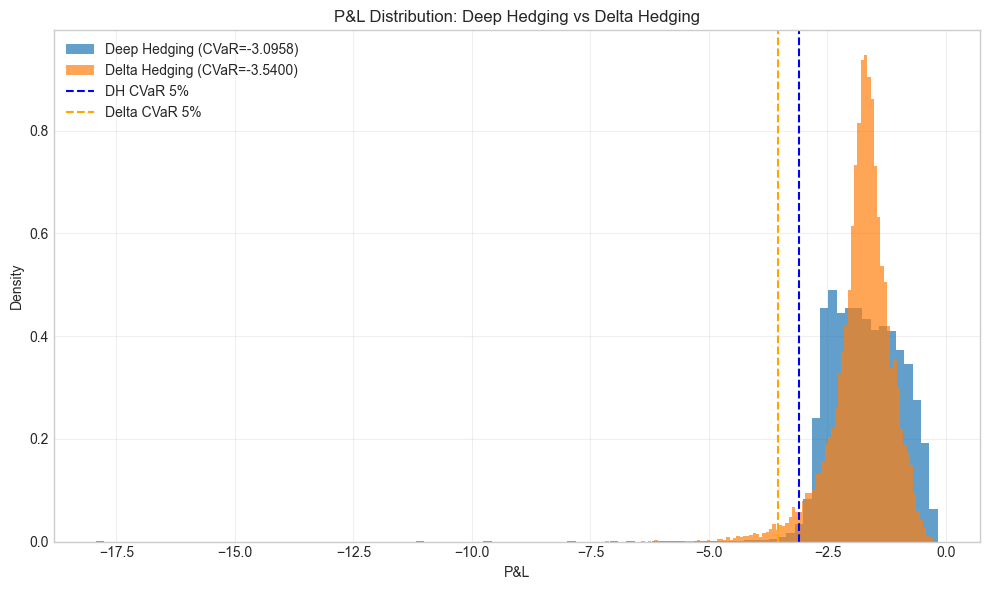

In [28]:
from src.evaluation.metrics import compute_cvar
from src.evaluation.baselines import DeltaHedgingBaseline

# Get Delta hedging P&L for comparison
r = heston_config.get('r', 0.02)
sigma = np.sqrt(heston_config.get('v_0', 0.0175))

delta_baseline = DeltaHedgingBaseline(K, T, r, 'call')
delta_deltas = delta_baseline.compute_deltas(S_test, v_test, sigma=sigma, dt=dt)

# Compute delta hedging P&L manually
c_prop = config['data'].get('transaction_cost', {}).get('c_prop', 0.001)
transaction_cost = c_prop
delta_pnl = delta_baseline.compute_pnl(S_test, Z_test, delta_deltas, transaction_cost=transaction_cost)

# --- CORRECTION ICI : Calcul explicite de la CVaR pour Delta Hedging ---
delta_cvar = compute_cvar(delta_pnl, 0.05)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Histogrammes avec les bons labels
ax.hist(all_pnl, bins=100, alpha=0.7, 
        label=f'Deep Hedging (CVaR={metrics["cvar_05"]:.4f})', density=True)
ax.hist(delta_pnl, bins=100, alpha=0.7, 
        label=f'Delta Hedging (CVaR={delta_cvar:.4f})', density=True) # Utilise la vraie CVaR

# Lignes verticales alignées sur la CVaR (et non la VaR)
ax.axvline(metrics['cvar_05'], color='blue', linestyle='--', label='DH CVaR 5%')
ax.axvline(delta_cvar, color='orange', linestyle='--', label='Delta CVaR 5%')

ax.set_xlabel('P&L')
ax.set_ylabel('Density')
ax.set_title('P&L Distribution: Deep Hedging vs Delta Hedging')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/baseline_pnl_distribution.pdf')
plt.show()

### Summary

Baseline model trained successfully. Key results:
- Deep Hedging learns an optimal premium parameter
- Outperforms Black-Scholes delta hedging on CVaR metric
- Model ready for pruning experiments (Lottery Ticket Hypothesis)